In [2]:
#%%
import sys
import os
root = os.path.abspath('')
sys.path.append(f'{root}/src')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from data.load_tdsf_data import load_tdsf_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def make_X_Y_cnsts(df, dt, ds, trunc, cnsts):

    # define shape of PINN I/O
    tv = np.arange(1,trunc+1)*dt
    tv = tv[::ds]

    # stack w,h, and t vectors to make inputs, X
    df['X'] = df.apply(lambda x: np.concatenate((x.YIELD*np.ones((tv.size,1)), 
                                                 x.DEPTH*np.ones((tv.size,1)), 
                                                 np.reshape(tv,(-1,1))), axis=1).astype(np.float32), 
                       axis=1)
    
    # truncate and decimate tdsf vectors to make targets, Y
    df['Y'] = df.DATA.map(lambda x: np.reshape(x[:trunc][::ds], (-1,1)).astype(np.float32))

    # 
    df['cnsts'] = df.apply(lambda x: (x[cnsts].values*np.ones((tv.size,1))).astype(np.float32),
                      axis=1)
    return df

# Define all hyperparams and run params here
algo = 'PINN'
study = 'test'

# Data params
vers = '002.1'
materials = ['Tuff-Rhyolite']
df = load_tdsf_data(vers, root)
df = df[df['material'].isin(materials)]
df = df.reset_index(drop=True)



trunc = 1000
ds = 10
dt = 0.001

# velocity model constants associated with the tdsf
cnsts = ['$h_o$', '$R_o$', '$y_0$', '$P_{1o}$', '$P_{2o}$', '$n$', 'C', '$V_S$', '$\\rho$']

# process inputs (wht) and targets (tdsf)
df = make_X_Y_cnsts(df, dt, ds, trunc, cnsts)
# df, df_test = train_test_split(df, test_size=.99) # random: test_size={.50, .99}


# # splits df into train and test by yield and depth quantiles
# ylds, dpths = df.YIELD.quantile(.5, interpolation='nearest'), df.DEPTH.quantile(.5, interpolation='nearest')
# Q1 = (df.YIELD >= ylds) & (df.DEPTH >= dpths)
# Q2 = (df.YIELD >= ylds) & (df.DEPTH <= dpths)
# Q3 = (df.YIELD <= ylds) & (df.DEPTH <= dpths)
# Q4 = (df.YIELD <= ylds) & (df.DEPTH >= dpths)


# splits df into train and test by yield and depth quantiles
qnts = [.1, .9]
ylds, dpths = df.YIELD.quantile(qnts, interpolation='nearest'), df.DEPTH.quantile(qnts, interpolation='nearest')
train_qnt = (df.YIELD >= ylds.min()) & (df.YIELD <= ylds.max()) & (df.DEPTH >= dpths.min()) & (df.DEPTH <= dpths.max())
df_train = df[train_qnt].reset_index(drop=True)
df_test = df[~train_qnt].reset_index(drop=True)


# print(f'Yield: {df.YIELD.unique()} Depth: {df.DEPTH.unique()}')
df_train.shape, df_test.shape

((6304, 59), (3282, 59))

In [3]:
# plot train and test yields and depths
if not os.path.exists(f'{root}/results/{study}'): os.makedirs(f'{root}/results/{study}')
plt.figure()
plt.scatter(df_train.YIELD, df_train.DEPTH, label='Train', color='black', alpha=0.2)
plt.scatter(df_test.YIELD, df_test.DEPTH, label='Test', color='red', alpha=0.2)
plt.xlabel('Yield')
plt.ylabel('Depth')
plt.legend()
plt.title('Train and Test domains')
plt.savefig(f'{root}/results/{study}/train_test_domains.png')
plt.close('all')

In [4]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, act, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = act
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss



def exact_solution(w,h,t,con):
    ''' 
    derived analytical expressions for ds/dw and ds/dh
    w: (b, 1, 1) - yields of the point source
    h: (b, 1, 1) - vertical source-to-receiver distance
    t: (b, 1, nt) - time points
    
    '''
    batch_size, _, nt = t.shape

    ho,Ro,go,P1,P2,n,pv,sv,rho = con

    Rel = Ro*((ho/h)**(1/n))*(w**(1/3))
    ga = go*Ro/Rel
    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu    
    wo = pv/Rel
    bet = (lam+2*mu)/(4*mu)
    alp = wo/(2*bet)
    p = wo*(1/2/bet-1/4/bet**2)**(1/2)

    def dF_(t):
        return (Rel*pv**2)/(4*mu*bet*p)*(-alp*torch.exp(-alp*t)*torch.sin(p*t) + p*torch.exp(-alp*t)*torch.cos(p*t))

    def dBdR_(t):
        t1 = t*ga*torch.exp(-ga*t)/Rel*P1*(h/ho)
        t2 = (t*ga*torch.exp(-ga*(t))+3*(1-torch.exp(-ga*(t))))/Rel*P2*((ho/h)**(1/3))*((Ro/Rel)**3)*(w**(0.87))
        return t1-t2
    
    dF = dF_(t)
    dBdR = dBdR_(t)
    
    # convolve
    dsdR = torch.nn.functional.conv1d(dF.view(1, batch_size, dF.size(-1)), 
                                    torch.flip(dBdR,dims=[-1]).view(batch_size, -1, dBdR.size(-1)), 
                                    padding='same', bias=None, groups=batch_size).view(batch_size, -1, nt)

    dRdw = 1/3*Ro*((ho/h)**(1/n))*(w**(-2/3))
    dRdh = -1/n*((ho/h)**(1/n))*(1/h)*(w**(1/3))
    dsdw = dsdR*dRdw
    dsdh = dsdR*dRdh
    
    return dF, dBdR, dsdR, dRdw, dRdh, dsdw, dsdh

## PDE as loss function. Thus would use the network which we call as u_theta
def f_partial(data, net, con, y):
    '''
    data: (b, nt, 3) unnormalized (..., [w,h,t]) vectors
    '''

    wvec = Variable(data[:,:,0], requires_grad=True) # (b, nt)
    hvec = Variable(data[:,:,1], requires_grad=True) # (b, nt)
    tvec = Variable(data[:,:,2], requires_grad=True) # (b, nt)

    x = (wvec*hvec*tvec).reshape(-1, tvec.shape[-1], 1)

    s = net((x - x.mean())/(x.std()))

    
    # remove normalization
    s = s*(y.max() - y.min()) + y.min()
    
    s_w = torch.autograd.grad(s.mean(), wvec, create_graph=True)[0]
    s_h = torch.autograd.grad(s.mean(), hvec, create_graph=True)[0]

    
    dF, dBdR, dsdR, dRdw, dRdh, dsdw, dsdh = exact_solution(wvec.mean(axis=-1).reshape(-1,1,1),
                                                            hvec.mean(axis=-1).reshape(-1,1,1),
                                                            tvec.reshape(data.shape[0],1,-1),
                                                            con)
    
    
    return s, s_w, dsdw, s_h, dsdh

# Training params
lr = 1.E-3
ntz = 100
cut = 10
nt = ntz-cut

# NN params
input_size = nt
output_size = input_size

# Model and training params
lam_d = 1. # data loss penalty

# lam_sh = 1.e-9 # Physics loss penalty for mse_sh
# lam_sw = 1.e-18 # Physics loss penalty for mse_sw
# scale = 0.00001 # noise scale

n_iter = 1000
n_trials = 3
n_samples = 1000


# shuffle and sample by time points
X, Y = np.stack(df.X.values)[:,cut:ntz], np.stack(df.Y.values)[:,cut:ntz]
X_test, Y_test = np.stack(df_test.X.values)[:,cut:ntz], np.stack(df_test.Y.values)[:,cut:ntz]

numIn = 1
numOut = Y.shape[-1]

X = torch.from_numpy(X.reshape(-1, nt, 3))
Y = torch.from_numpy(Y.reshape(-1, nt, 1))

X_test = torch.from_numpy(X_test.reshape(-1, nt, 3))
Y_test = torch.from_numpy(Y_test.reshape(-1, nt, 1))

print(X.shape, Y.shape, X_test.shape, Y_test.shape)

con = [122., # ho
       202., # Ro
       26., # go
       3.6*1e6, # P1
       5.0*1e6, # P2
       2.4, # n
       3500, # pv
       2021, # sv
       2000 # rho
        ]



# loss, loss_d, loss_b, loss_sw, loss_sh, s_w, dsdw, s_h, dsdh = out
# phy_loss_tr = loss_sw + loss_sh

torch.Size([9586, 90, 3]) torch.Size([9586, 90, 1]) torch.Size([3282, 90, 3]) torch.Size([3282, 90, 1])


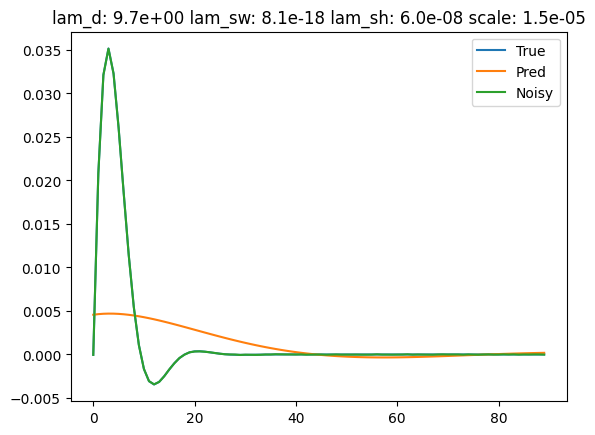

[I 2024-03-13 06:43:49,969] Trial 6 finished with value: 5.459848398459144e-05 and parameters: {'lam_sw': 8.133561677819697e-18, 'lam_sh': 6.011905503552175e-08, 'scale': 1.5227889052857765e-05, 'lam_d': 9.654317938234376}. Best is trial 0 with value: 7.99892222858034e-06.


Trial 6 finished with value: 5.459848398459144e-05 and parameters: {'lam_sw': 8.133561677819697e-18, 'lam_sh': 6.011905503552175e-08, 'scale': 1.5227889052857765e-05, 'lam_d': 9.654317938234376}. Best is trial 0 with value: 7.99892222858034e-06.


[W 2024-03-13 06:44:42,474] Trial 7 failed with parameters: {'lam_sw': 1.2920758774137434e-18, 'lam_sh': 3.521971778077321e-09, 'scale': 0.0005941598046717557, 'lam_d': 1.4109220100964215} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_230312/310633978.py", line 51, in train
    mse_d = criterion(output[mask],target[mask]+noise[mask])
KeyboardInterrupt


Trial 7 failed with parameters: {'lam_sw': 1.2920758774137434e-18, 'lam_sh': 3.521971778077321e-09, 'scale': 0.0005941598046717557, 'lam_d': 1.4109220100964215} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_230312/310633978.py", line 51, in train
    mse_d = criterion(output[mask],target[mask]+noise[mask])
KeyboardInterrupt


[W 2024-03-13 06:44:42,475] Trial 7 failed with value None.


Trial 7 failed with value None.


KeyboardInterrupt: 

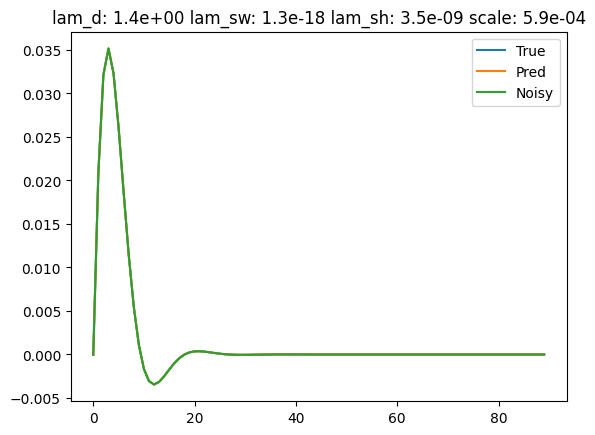

In [12]:
import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.trial import TrialState

import logging 

def train(trial):
    # Setup model and optimizer.
    model = NeuralNet(input_dimension=1, 
                    output_dimension=1, 
                    n_hidden_layers=6, 
                    neurons=96,
                    act = torch.nn.GELU('tanh'),
                    regularization_param=0., 
                    regularization_exp=2,
                    retrain_seed=128).to(device)

    # Select Optimizer and Loss Criterion
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', .9999999, 100, cooldown=25)

    model.train()

    data, target = Variable(X, requires_grad=True).to(device), Variable(Y, requires_grad=True).to(device)
    
    # create Y-D quantile mask for data loss
    mask = (data[:,0,0] >= ylds.min()) & (data[:,0,0] <= ylds.max()) & (data[:,0,1] >= dpths.min()) & (data[:,0,1] <= dpths.max())
    
    lam_sw = trial.suggest_float("lam_sw", 1.e-18, 1.e-10, log=True)
    lam_sh = trial.suggest_float("lam_sh", 1.e-9, 1.e-6, log=True)
    scale = trial.suggest_float("scale", 1.e-5, 1.e-2, log=True)
    lam_d = trial.suggest_float("lam_d", 1.e-2, 1.e2, log=True)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ln1, = ax.plot(Y[0].squeeze(), label='True')
    ln2, = ax.plot(Y[0].squeeze(), label='Pred')
    ln3, = ax.plot(Y[0].squeeze(), label='Noisy')
    plt.legend()
    plt.title(f'lam_d: {lam_d:.1e} lam_sw: {lam_sw:.1e} lam_sh: {lam_sh:.1e} scale: {scale:.1e}')
    
    for i in range(n_iter):
        noise = scale*torch.randn_like(target)
        
        optimizer.zero_grad()
        
        output, s_w, dsdw, s_h, dsdh = f_partial(data, model, con, target)
        
        #data loss
        mse_d = criterion(output[mask],target[mask]+noise[mask]) 
        loss_d = lam_d*mse_d

        # boundary loss
        t0 = torch.tensor(0.).to(device)
        tl = torch.tensor(0.).to(device)
        loss_b = criterion(output[:,0,:], t0) +  criterion(output[:,-1,:], tl)
        
        # physiscs loss
        mse_sw = criterion(s_w.flatten().squeeze(), dsdw.flatten().squeeze())
        mse_sh = criterion(s_h.flatten().squeeze(), dsdh.flatten().squeeze())
        
        loss_sw = lam_sw*mse_sw
        loss_sh = lam_sh*mse_sh

        loss = loss_d + loss_b + loss_sw + loss_sh
               
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        trial.report(mse_d.mean().item(), step=i)

        print(f'Iteration: {i} Loss: {loss.item():.3e} da-{loss_d:.3e} bo-{loss_b:.3e} sw-{loss_sw:.3e} sh-{loss_sh:.3e} lr: {scheduler._last_lr[0]:.3e}', end='\r')
        if i == n_iter-1:
            ln1.set_ydata(Y[0].squeeze())
            ln2.set_ydata(output[0].squeeze().detach().cpu().numpy())
            ln3.set_ydata(Y[0].squeeze()+noise[0].detach().cpu().squeeze())
            display.clear_output(wait=True)
            display.display(pl.gcf())
    
    fig.savefig(f'{results_path}/{trial.number}.png')
    fig.clear()
    plt.close()

    torch.save(model, f'{results_path}/{trial.number}.pt')
    
    model.eval()
    data, target = Variable(X_test, requires_grad=True).to(device), Variable(Y_test, requires_grad=True).to(device)
    output, s_w, dsdw, s_h, dsdh = f_partial(data, model, con, target)
        
    #data loss
    mse_d = criterion(output,target) 
    
    return mse_d.mean().item()

import pathlib
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "tdsf-study"  # Unique identifier of the study.

# Save results path
results_path = f'{root}/experiments/{study_name}'
pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)

storage_name = "sqlite:///{}.db".format(results_path)
study = optuna.create_study(study_name=study_name, storage=storage_name, sampler=RandomSampler(), load_if_exists=True)

study.optimize(train, n_trials=n_trials)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

# root = '/home/mitch/PythonProjects/learn_sciml/tdsf-pinn'
root = os.path.normpath(os.getcwd())
study_name = "tdsf-study" #"tdsf-with-lam_d-study" #    # Unique identifier of the study.
results_path = f'{root}/experiments/{study_name}'
storage_name = "sqlite:///{}.db".format(results_path)
study = optuna.load_study(study_name, storage_name)


In [ ]:
plot_timeline(study)

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_intermediate_values(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
fig = plot_slice(study)
fig.show()

In [ ]:
plot_param_importances(study)

In [ ]:
plot_rank(study)

In [ ]:
plot_contour(study)